# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.60KFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

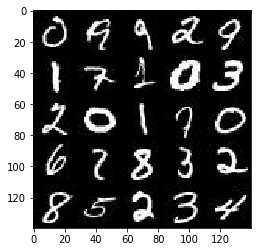

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

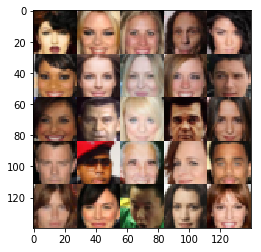

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name = 'learn_rate')

    return input_real, input_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # 参考：DCGAN paper - https://arxiv.org/pdf/1511.06434.pdf
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # 参考：DCGAN paper - https://arxiv.org/pdf/1511.06434.pdf
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3(channel)now

        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    samples, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size = [batch_size, z_dim])
                               
                feed_dict = {input_real: batch_images,input_z: batch_z,learn_rate: learning_rate}
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict = feed_dict)
                _ = sess.run(g_opt, feed_dict = feed_dict)
                
                print_every = 10
                if steps % print_every == 0:
                    # 在每个epoch之后得到并打印losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                show_every = 100
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 2.1867
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 0.6526
Epoch 1/2... Discriminator Loss: 0.3010... Generator Loss: 1.6691
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.3375
Epoch 1/2... Discriminator Loss: 0.1500... Generator Loss: 9.2122
Epoch 1/2... Discriminator Loss: 0.2359... Generator Loss: 1.8928
Epoch 1/2... Discriminator Loss: 0.1676... Generator Loss: 3.1570
Epoch 1/2... Discriminator Loss: 0.3510... Generator Loss: 4.7029
Epoch 1/2... Discriminator Loss: 0.4345... Generator Loss: 8.9103
Epoch 1/2... Discriminator Loss: 0.2255... Generator Loss: 3.7834


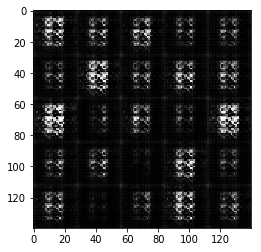

Epoch 1/2... Discriminator Loss: 0.2390... Generator Loss: 2.1346
Epoch 1/2... Discriminator Loss: 0.5517... Generator Loss: 1.6707
Epoch 1/2... Discriminator Loss: 0.1196... Generator Loss: 3.8415
Epoch 1/2... Discriminator Loss: 0.1046... Generator Loss: 3.2066
Epoch 1/2... Discriminator Loss: 0.2073... Generator Loss: 2.2475
Epoch 1/2... Discriminator Loss: 0.1532... Generator Loss: 2.6883
Epoch 1/2... Discriminator Loss: 0.1359... Generator Loss: 2.9118
Epoch 1/2... Discriminator Loss: 0.1534... Generator Loss: 2.5428
Epoch 1/2... Discriminator Loss: 0.1131... Generator Loss: 3.5204
Epoch 1/2... Discriminator Loss: 0.0826... Generator Loss: 3.6465


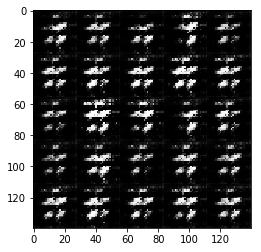

Epoch 1/2... Discriminator Loss: 0.0642... Generator Loss: 3.5116
Epoch 1/2... Discriminator Loss: 0.0505... Generator Loss: 4.0481
Epoch 1/2... Discriminator Loss: 0.0319... Generator Loss: 4.2530
Epoch 1/2... Discriminator Loss: 0.0446... Generator Loss: 4.2125
Epoch 1/2... Discriminator Loss: 0.0629... Generator Loss: 3.7292
Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 7.4310
Epoch 1/2... Discriminator Loss: 0.2261... Generator Loss: 9.0981
Epoch 1/2... Discriminator Loss: 0.0858... Generator Loss: 4.2089
Epoch 1/2... Discriminator Loss: 0.1336... Generator Loss: 2.6127
Epoch 1/2... Discriminator Loss: 0.0409... Generator Loss: 4.3116


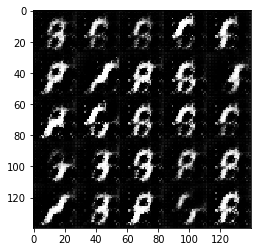

Epoch 1/2... Discriminator Loss: 0.0381... Generator Loss: 4.0494
Epoch 1/2... Discriminator Loss: 0.0466... Generator Loss: 3.8769
Epoch 1/2... Discriminator Loss: 0.0575... Generator Loss: 3.4574
Epoch 1/2... Discriminator Loss: 0.0626... Generator Loss: 3.3922
Epoch 1/2... Discriminator Loss: 0.0463... Generator Loss: 3.9543
Epoch 1/2... Discriminator Loss: 0.0588... Generator Loss: 3.4508
Epoch 1/2... Discriminator Loss: 0.0361... Generator Loss: 4.2874
Epoch 1/2... Discriminator Loss: 0.0602... Generator Loss: 3.2871
Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 2.6477
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 10.1288


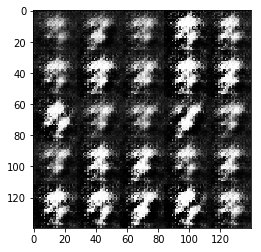

Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 0.1297... Generator Loss: 2.9735
Epoch 1/2... Discriminator Loss: 0.1979... Generator Loss: 2.3098
Epoch 1/2... Discriminator Loss: 0.1664... Generator Loss: 2.4774
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 3.5246
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 3.4478
Epoch 2/2... Discriminator Loss: 0.4283... Generator Loss: 6.1424
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 0.3692... Generator Loss: 2.5452
Epoch 2/2... Discriminator Loss: 0.2123... Generator Loss: 2.9772


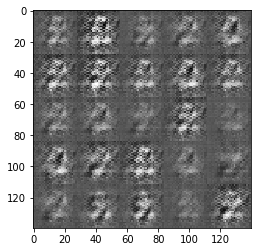

Epoch 2/2... Discriminator Loss: 0.1707... Generator Loss: 2.8406
Epoch 2/2... Discriminator Loss: 0.3037... Generator Loss: 1.9107
Epoch 2/2... Discriminator Loss: 0.2486... Generator Loss: 2.3902
Epoch 2/2... Discriminator Loss: 0.2546... Generator Loss: 2.2589
Epoch 2/2... Discriminator Loss: 0.2650... Generator Loss: 2.0976
Epoch 2/2... Discriminator Loss: 0.1523... Generator Loss: 2.5512
Epoch 2/2... Discriminator Loss: 0.2282... Generator Loss: 2.6280
Epoch 2/2... Discriminator Loss: 0.1723... Generator Loss: 2.4382
Epoch 2/2... Discriminator Loss: 0.1866... Generator Loss: 2.9704
Epoch 2/2... Discriminator Loss: 0.1625... Generator Loss: 2.7735


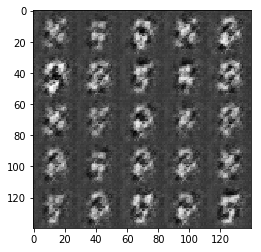

Epoch 2/2... Discriminator Loss: 0.1400... Generator Loss: 2.6833
Epoch 2/2... Discriminator Loss: 0.2482... Generator Loss: 3.1750
Epoch 2/2... Discriminator Loss: 0.3006... Generator Loss: 1.9915
Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 6.1434
Epoch 2/2... Discriminator Loss: 0.2862... Generator Loss: 2.0223
Epoch 2/2... Discriminator Loss: 0.2334... Generator Loss: 1.9613
Epoch 2/2... Discriminator Loss: 0.3675... Generator Loss: 4.5726
Epoch 2/2... Discriminator Loss: 0.1575... Generator Loss: 2.8535
Epoch 2/2... Discriminator Loss: 0.1157... Generator Loss: 3.2583
Epoch 2/2... Discriminator Loss: 0.1472... Generator Loss: 3.4269


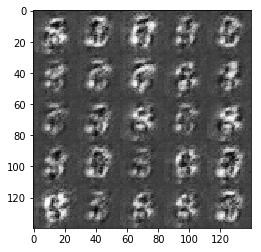

Epoch 2/2... Discriminator Loss: 0.1850... Generator Loss: 3.1844
Epoch 2/2... Discriminator Loss: 0.1860... Generator Loss: 2.6075
Epoch 2/2... Discriminator Loss: 0.0740... Generator Loss: 3.5862
Epoch 2/2... Discriminator Loss: 0.1045... Generator Loss: 3.3114
Epoch 2/2... Discriminator Loss: 0.0909... Generator Loss: 3.1561
Epoch 2/2... Discriminator Loss: 0.4097... Generator Loss: 5.9025
Epoch 2/2... Discriminator Loss: 0.4013... Generator Loss: 1.7910
Epoch 2/2... Discriminator Loss: 0.2067... Generator Loss: 2.4383
Epoch 2/2... Discriminator Loss: 0.1551... Generator Loss: 3.0995
Epoch 2/2... Discriminator Loss: 0.1236... Generator Loss: 2.8717


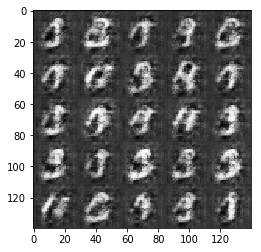

Epoch 2/2... Discriminator Loss: 0.1087... Generator Loss: 3.0925
Epoch 2/2... Discriminator Loss: 0.1317... Generator Loss: 3.0067
Epoch 2/2... Discriminator Loss: 0.0880... Generator Loss: 3.2582
Epoch 2/2... Discriminator Loss: 0.1126... Generator Loss: 3.1070
Epoch 2/2... Discriminator Loss: 0.0906... Generator Loss: 4.0435
Epoch 2/2... Discriminator Loss: 0.0623... Generator Loss: 4.0074
Epoch 2/2... Discriminator Loss: 0.0906... Generator Loss: 3.6586
Epoch 2/2... Discriminator Loss: 0.0823... Generator Loss: 3.8608
Epoch 2/2... Discriminator Loss: 0.0719... Generator Loss: 4.8352
Epoch 2/2... Discriminator Loss: 0.0966... Generator Loss: 3.2794


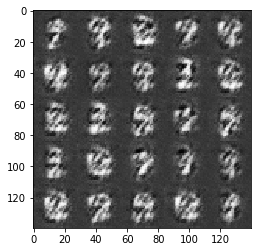

Epoch 2/2... Discriminator Loss: 0.0987... Generator Loss: 3.2084
Epoch 2/2... Discriminator Loss: 0.0747... Generator Loss: 4.0957
Epoch 2/2... Discriminator Loss: 0.0452... Generator Loss: 4.2043


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 1.7646
Epoch 1/1... Discriminator Loss: 0.2296... Generator Loss: 5.3793
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 5.1027
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 0.3839... Generator Loss: 1.3107
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 2.7545
Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 2.6595
Epoch 1/1... Discriminator Loss: 0.1945... Generator Loss: 2.4306


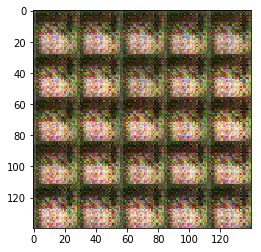

Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 1.9816
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 0.1048... Generator Loss: 4.2382
Epoch 1/1... Discriminator Loss: 0.1709... Generator Loss: 5.8813
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 0.1935... Generator Loss: 2.1780
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 4.4199
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 2.8857
Epoch 1/1... Discriminator Loss: 0.0792... Generator Loss: 3.0934
Epoch 1/1... Discriminator Loss: 0.0409... Generator Loss: 6.9339


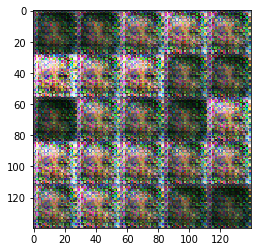

Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 3.2517
Epoch 1/1... Discriminator Loss: 0.0507... Generator Loss: 4.4179
Epoch 1/1... Discriminator Loss: 0.0541... Generator Loss: 10.7171
Epoch 1/1... Discriminator Loss: 0.3021... Generator Loss: 11.7811
Epoch 1/1... Discriminator Loss: 0.2210... Generator Loss: 3.0065
Epoch 1/1... Discriminator Loss: 0.2175... Generator Loss: 2.7195
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.6403
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 3.4863
Epoch 1/1... Discriminator Loss: 2.1991... Generator Loss: 0.6917


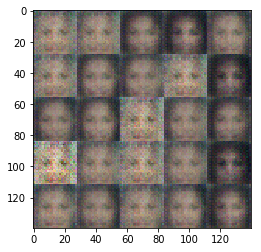

Epoch 1/1... Discriminator Loss: 1.8693... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.5883
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.4307


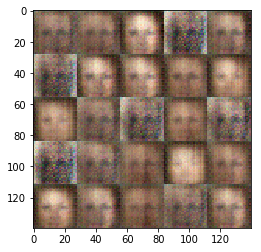

Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 1.6197
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.7642
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.6396
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 2.5439
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.2752


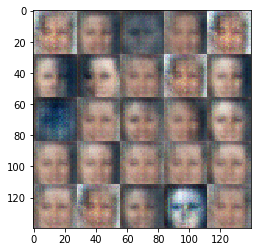

Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 1.8361
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 1.6174
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.6883


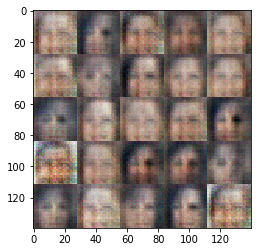

Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 0.6503... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.7649
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 4.0271
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 3.4485
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 0.9885


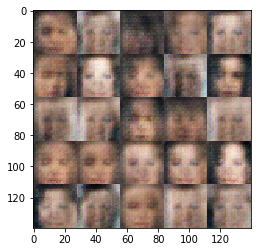

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 3.2341
Epoch 1/1... Discriminator Loss: 0.2699... Generator Loss: 2.5101
Epoch 1/1... Discriminator Loss: 0.2984... Generator Loss: 2.0715
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.4594
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.5832
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.8762
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 2.0824
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 2.5103... Generator Loss: 5.5282


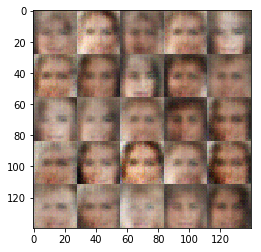

Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 3.2908
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 3.4963
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 2.6991
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 2.2463
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 3.5071
Epoch 1/1... Discriminator Loss: 0.2130... Generator Loss: 2.2954
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 1.9625
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 0.8342


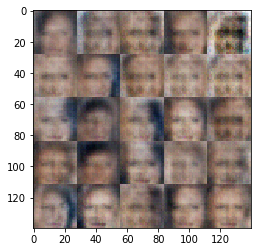

Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 4.3118
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 1.6584
Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 1.9649
Epoch 1/1... Discriminator Loss: 0.2855... Generator Loss: 2.1140
Epoch 1/1... Discriminator Loss: 0.2617... Generator Loss: 4.0128
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 1.7152
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.1993


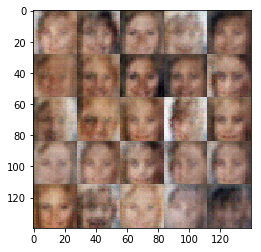

Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 0.2747... Generator Loss: 3.1120
Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 4.6653
Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 2.8456
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 1.7815
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 0.1953... Generator Loss: 2.3103


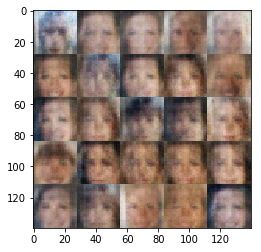

Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 6.8337
Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 2.2098
Epoch 1/1... Discriminator Loss: 0.1410... Generator Loss: 3.6022
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 3.5256
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 3.8511
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 3.2863
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 1.7426
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.5523


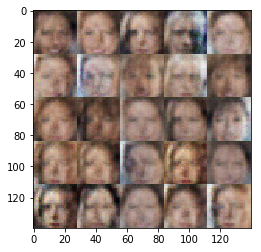

Epoch 1/1... Discriminator Loss: 0.2373... Generator Loss: 3.3750
Epoch 1/1... Discriminator Loss: 0.1117... Generator Loss: 3.8824
Epoch 1/1... Discriminator Loss: 0.2964... Generator Loss: 1.8374
Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 8.7812
Epoch 1/1... Discriminator Loss: 0.3017... Generator Loss: 2.5908
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 1.6384
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 3.1570
Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 2.7199
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 1.4757


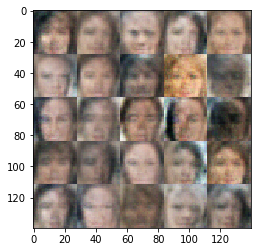

Epoch 1/1... Discriminator Loss: 0.0503... Generator Loss: 6.0045
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 4.8473
Epoch 1/1... Discriminator Loss: 0.1160... Generator Loss: 5.6893
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 0.1400... Generator Loss: 2.4573
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 0.2666... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 6.0294
Epoch 1/1... Discriminator Loss: 0.1357... Generator Loss: 5.8951
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.3795


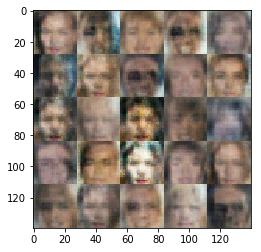

Epoch 1/1... Discriminator Loss: 0.2836... Generator Loss: 9.8036
Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 9.0399
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 0.2295... Generator Loss: 1.9465
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 2.0113
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 3.6917
Epoch 1/1... Discriminator Loss: 0.1738... Generator Loss: 2.3230
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 3.5065
Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 3.9061


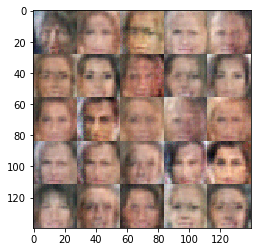

Epoch 1/1... Discriminator Loss: 0.1201... Generator Loss: 3.8372
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 1.3133
Epoch 1/1... Discriminator Loss: 0.0526... Generator Loss: 5.7218
Epoch 1/1... Discriminator Loss: 0.0969... Generator Loss: 5.9691
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 0.1466... Generator Loss: 2.5652
Epoch 1/1... Discriminator Loss: 0.1469... Generator Loss: 7.3397
Epoch 1/1... Discriminator Loss: 0.1840... Generator Loss: 2.3683


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。